# Cells below allow to run our code in Colab easily. Enjoy! :)

In [0]:
#!git clone https://github.com/82492749123082/farich-pics.git -b dev #clone dev-branch
#%cd farich-pics
#!pip install gdown -q #install package

Cloning into 'farich-pics'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 285 (delta 130), reused 221 (delta 77), pack-reused 0
Receiving objects: 100% (285/285), 915.59 KiB | 3.42 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/farich-pics


In [0]:
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl" #many circles dataset
url_nn, path_nn = "1Iur3_vwlelevQClxH9HYuBL3PBkEGsES", "nn.pth"

In [15]:
!gdown --id $url_dataset -O $dataset_path
!gdown --id $url_nn -O $path_nn

Downloading...
From: https://drive.google.com/uc?id=1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV
To: /content/drive/My Drive/farich/farich-pics/dataset.pkl
99.2MB [00:01, 97.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Iur3_vwlelevQClxH9HYuBL3PBkEGsES
To: /content/drive/My Drive/farich/farich-pics/nn.pth
176MB [00:02, 87.0MB/s]


In [0]:
import pickle

with open(dataset_path, "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse, Circle, Rectangle

%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/farich/farich-pics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/farich/farich-pics


Then create the class instance:

In [0]:
import torch
import farichlib
from farichlib.Dataset import Dataset

## Let's create datasets with different noise levels and look at nn response for them

In [22]:
datasets = []
noises = np.linspace(start=0.01, stop=0.2, num=20)
for noise_level in noises:
  my_dataset = Dataset(noise_level=noise_level)
  my_dataset.load(dataset_path)
  datasets.append( my_dataset )
datasets[0]

In [23]:
datasets[0][0] #check

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([1239.0398,  948.6401,  948.6401]),
  'boxes': tensor([[48.4000, 11.4000, 83.6000, 46.6000],
          [14.6000, 33.6000, 45.4000, 64.4000],
          [30.6000, 32.6000, 61.4000, 63.4000]]),
  'image_id': tensor([0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0.

In [0]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [0]:
model = get_model(path_nn) #use pretrained model on noiseless data

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [0]:
from farichlib import utils
from farichlib.utils import show_nn_result

# Let's draw some pics

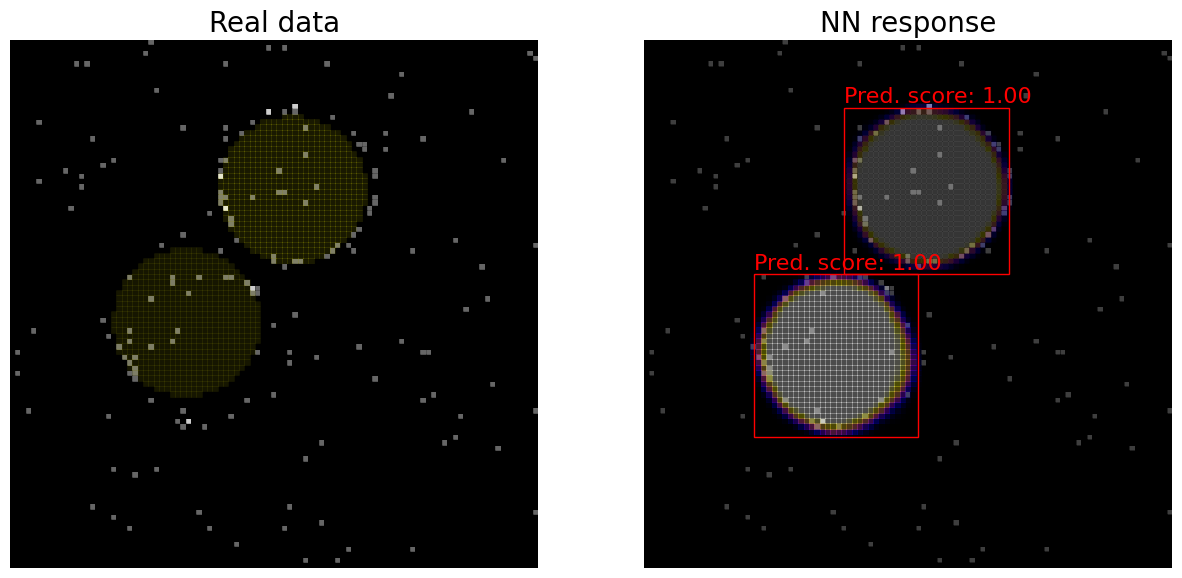

In [29]:
ind = random.randint(0, len(datasets[0])-1)
show_nn_result(model, datasets[0][ind], 0.99)

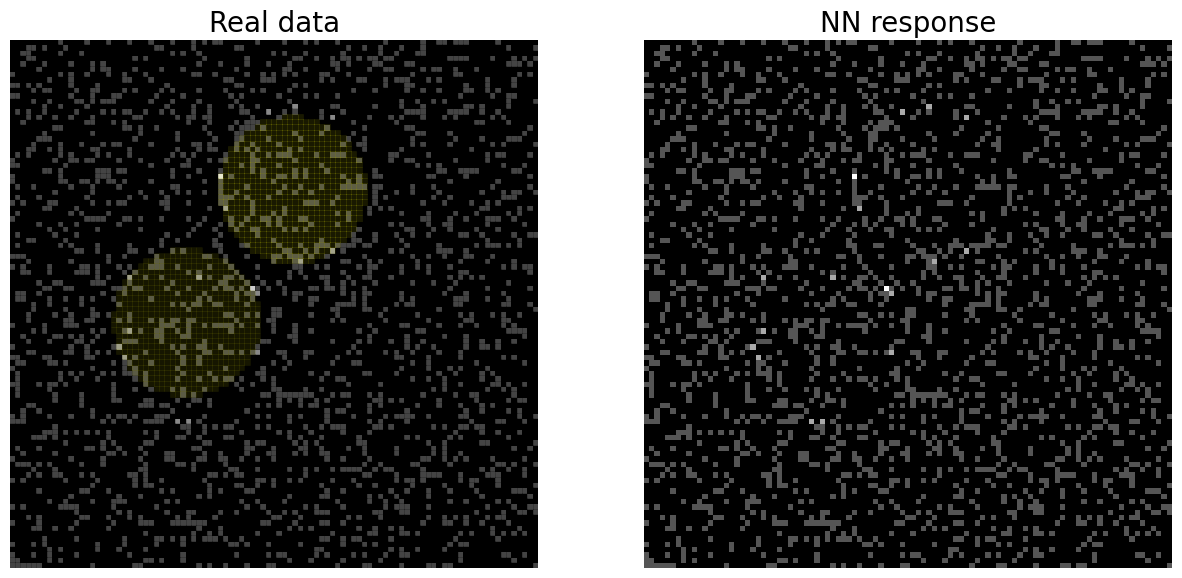

In [30]:
show_nn_result(model, datasets[-1][ind], 0.99)

Будем считать, что если IoU истинной и предсказанной масок больше iou_thr (в нашем случае 0.8), то они соответствуют одному и тому же кругу

Также будем использовать скор нейросети, равный 0.9

Хотим найти recall в зависимости от истинного числа кругов

In [0]:
def iou_score2(mask1, masks2):
    masks1 = np.broadcast_to(mask1, masks2.shape)
    inter = np.logical_and(masks1, masks2).sum(axis=(1,2))
    union = np.logical_or(masks1, masks2).sum(axis=(1,2))
    return inter/union

In [0]:
def iou_imgage(dataset, index, nn_thr=0.9):
    img, bbox = dataset[index]
    masks1 = bbox['masks'][:].numpy().astype('bool')
    model.eval()
    prediction = model([img.to(device)])
    try:
        masks2 = (prediction[0]['masks'][:,0].cpu().detach().numpy() > 0.5).astype('bool')
        scores = prediction[0]['scores'].cpu().detach().numpy()
    except:
        return np.array([[]])
    rates = []
    for mask1 in masks1:
      rates.append(iou_score2(mask1, masks2))
    # appending scores to the end
    rates.append(scores)
    return rates

In [37]:
r = iou_imgage(dataset = datasets[0], index=0)
r

[array([0.02175439, 0.89557321, 0.        , 0.        ]),
 array([0.18046512, 0.        , 0.85358255, 0.00226415]),
 array([0.91415663, 0.01158038, 0.14946962, 0.        ]),
 array([0.9999738 , 0.99996793, 0.9989222 , 0.16809537], dtype=float32)]

In [0]:
# сейчас будет долго 
n_images = 200
iou_thr = 0.8
r = [ iou_imgage(dataset=dataset, index=i) for i in range(0,n_images) for dataset in datasets]
rr = np.array(r).reshape((n_images,20))

In [0]:
def n_circles(r, iou_thr, nn_thr):
  arr = np.array( [r[i] for i in range(len(r)-1)] )
  try:
    b = np.array( [1*((row == np.max(row)) & (row > iou_thr)) for row in arr] )
  except:
    return -1,-1
  nn_goodness = 1*(r[-1] > nn_thr)
  is_good_circle = ( np.sum(b, axis=0)==1 ) & nn_goodness
  is_bad_circle = ( np.sum(b, axis=0)!=1 ) & nn_goodness
  return  np.sum( is_good_circle ), np.sum( is_bad_circle ) 

Теперь узнаем, как всё это (precision, recall) зависит от скора нейронной сети 

In [0]:
def evaluate_metrics(r, precision, recall, threshold):
  recall_tot = np.array([0.,0.,0.])
  precision_tot = np.array([0.,0.,0.])
  n_tot = [0,0,0]
  n_nn_tot = [0,0,0]
  for elem in r:
    index = len(elem)-2 # 0 for 1 circle, 1 --- for 2,kinogo.by 2 --- for 3 circles
    tp_fn = len(elem)-1 
    tp, fp = n_circles(elem, iou_thr=0.8, nn_thr=threshold)
    tp_fp = tp + fp
    n_tot[index] += tp_fn
    n_nn_tot[index] += tp_fp
    recall_tot[index] += tp 
    precision_tot[index] += tp 
  for i in range(3):
    recall_tot[i] = recall_tot[i]/n_tot[i]
    precision_tot[i] = precision_tot[i]/n_nn_tot[i]
  precision = np.concatenate((precision, precision_tot))
  recall = np.concatenate((recall, recall_tot)) 
  return precision, recall

In [92]:
rr[:,0].shape

(100,)

## Нарисуем precision, recall для разных уровней шума

In [0]:
def plot_scores(index):
  precision = np.array([])
  recall = np.array([])
  threshold = np.linspace(0, 0.999, 90)
  for thr in threshold:
    precision, recall = evaluate_metrics(r=list(rr[:,index]), precision=precision, recall=recall, threshold=thr)
  precision = np.reshape(precision, (-1,3))
  recall = np.reshape(recall, (-1,3))  
  precision1, precision2, precision3 = precision[:,0], precision[:,1], precision[:,2] 
  recall1, recall2, recall3 = recall[:,0], recall[:,1], recall[:,2]
  plt.figure(dpi=130,figsize=(8,4))
  plt.subplot(121)
  plt.plot(threshold, precision1, label='Precision, n=1')
  plt.plot(threshold, precision2, label='Precision, n=2')
  plt.plot(threshold, precision3, label='Precision, n=3')
  plt.grid(linestyle='--')
  plt.xlabel('Predictor score threshold for noise=%d percent'%(index+1))
  plt.legend()
  plt.subplot(122)
  plt.plot(threshold, recall1, label='Recall, n=1')
  plt.plot(threshold, recall2, label='Recall, n=2')
  plt.plot(threshold, recall3, label='Recall, n=3')
  plt.grid(linestyle='--')
  plt.xlabel('Predictor score threshold for noise=%d percent'%(index+1))
  plt.legend()
  return

In [110]:
for i in range(20):
  plot_scores(i)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
lens = []
for i in range(1000):
  img, bbox = dataset_test[i]
  lens.append(len(bbox['masks'][:]))
np.unique(np.array(lens), return_counts=True)

(array([1, 2, 3]), array([333, 324, 343]))